In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, Conv2D, Input
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DIRECTORY = r"../input/car-damage-detection/data1a/training/"
DIRECTORY2=r"../input/car-damage-detection/data1a/validation/"
CATEGORIES = ["00-damage", "01-whole"]

data_train = []
labels_train = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)  
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data_train.append(image)
        labels_train.append(category)

data_validation = []
pure_test_images  = []
labels_validation = []
        
for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
        img_path =os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        pure_test_images.append(image)
        image = preprocess_input(image)
        data_validation.append(image)
        labels_validation.append(category)

lb = LabelBinarizer()
labels_train = lb.fit_transform(labels_train)
labels_train = to_categorical(labels_train)
labels_validation = lb.fit_transform(labels_validation)
labels_validation = to_categorical(labels_validation)

data_train = np.array(data_train, dtype="float32")
data_validation = np.array(data_validation, dtype="float32")

labels_train = np.array(labels_train)
labels_validation = np.array(labels_validation)

X_train, X_test, y_train, y_test = data_train, data_validation, labels_train, labels_validation

In [3]:
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest",
)

In [4]:
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 64
LEARNING_RATE = 1.e-5
EPOCHS = 5
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_tensor=Input(shape=INPUT_SHAPE))

fine_tuned_model = base_model.output
fine_tuned_model = MaxPooling2D(pool_size=(7,7))(fine_tuned_model)
fine_tuned_model = Flatten()(fine_tuned_model)
fine_tuned_model = Dense(400, activation='relu')(fine_tuned_model)
fine_tuned_model = Dropout(0.2)(fine_tuned_model)
fine_tuned_model = Dense(120, activation='relu')(fine_tuned_model)
fine_tuned_model = Dense(2, activation='softmax')(fine_tuned_model)

model = Model(inputs=base_model.input, outputs=fine_tuned_model)

In [5]:
for layer in base_model.layers:
    layer.trainable = False
opt = Adam(lr=LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [6]:
hist = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                steps_per_epoch=len(X_train) // BATCH_SIZE,
                validation_data=(X_test, y_test),
                validation_steps=len(X_test) // BATCH_SIZE,
                epochs=EPOCHS)

Epoch 1/5
28/28 [==============================] - 43s 1s/step - loss: 2.7070 - accuracy: 0.6971 - val_loss: 0.5278 - val_accuracy: 0.8543
Epoch 2/5
28/28 [==============================] - 27s 978ms/step - loss: 0.5330 - accuracy: 0.8553 - val_loss: 0.2619 - val_accuracy: 0.9109
Epoch 3/5
28/28 [==============================] - 28s 1s/step - loss: 0.3407 - accuracy: 0.8823 - val_loss: 0.2242 - val_accuracy: 0.9239
Epoch 4/5
28/28 [==============================] - 28s 1s/step - loss: 0.3042 - accuracy: 0.8868 - val_loss: 0.2342 - val_accuracy: 0.9087
Epoch 5/5
28/28 [==============================] - 27s 960ms/step - loss: 0.2426 - accuracy: 0.9065 - val_loss: 0.1913 - val_accuracy: 0.9391


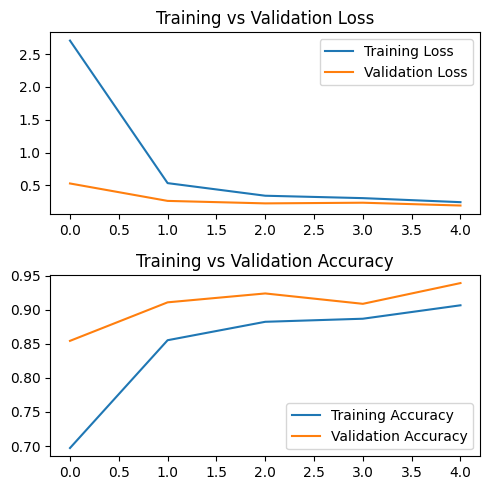

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(5,5))
axes = axes.flatten()
axes[0].plot(hist.history['loss'])
axes[0].plot(hist.history['val_loss'])
axes[0].set_title('Training vs Validation Loss')
axes[0].legend(['Training Loss', 'Validation Loss'])

axes[1].plot(hist.history['accuracy'])
axes[1].plot(hist.history['val_accuracy'])
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()

In [8]:
cross_entropy_loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Cross Entropy Loss = {cross_entropy_loss}")
print(f"Test Accuracy = {round(accuracy*100,2)}%")

15/15 [==============================] - 3s 138ms/step - loss: 0.1913 - accuracy: 0.9391
Test Cross Entropy Loss = 0.19133520126342773
Test Accuracy = 93.91%


In [9]:
def get_predictions(model, X_test):
    predictions = model.predict(X_test)
    predicted_labels = [np.argmax(predicted) for predicted in predictions]
    return predicted_labels

In [10]:
predictions = get_predictions(model, X_test)
predicted_label = ['Not Damaged' if predicted == 1 else 'Damaged' for predicted in predictions]
real_labels = [np.argmax(label) for label in labels_validation]
real_labels = ['Not Damaged' if label == 1 else 'Damaged' for label in real_labels]

15/15 [==============================] - 2s 97ms/step


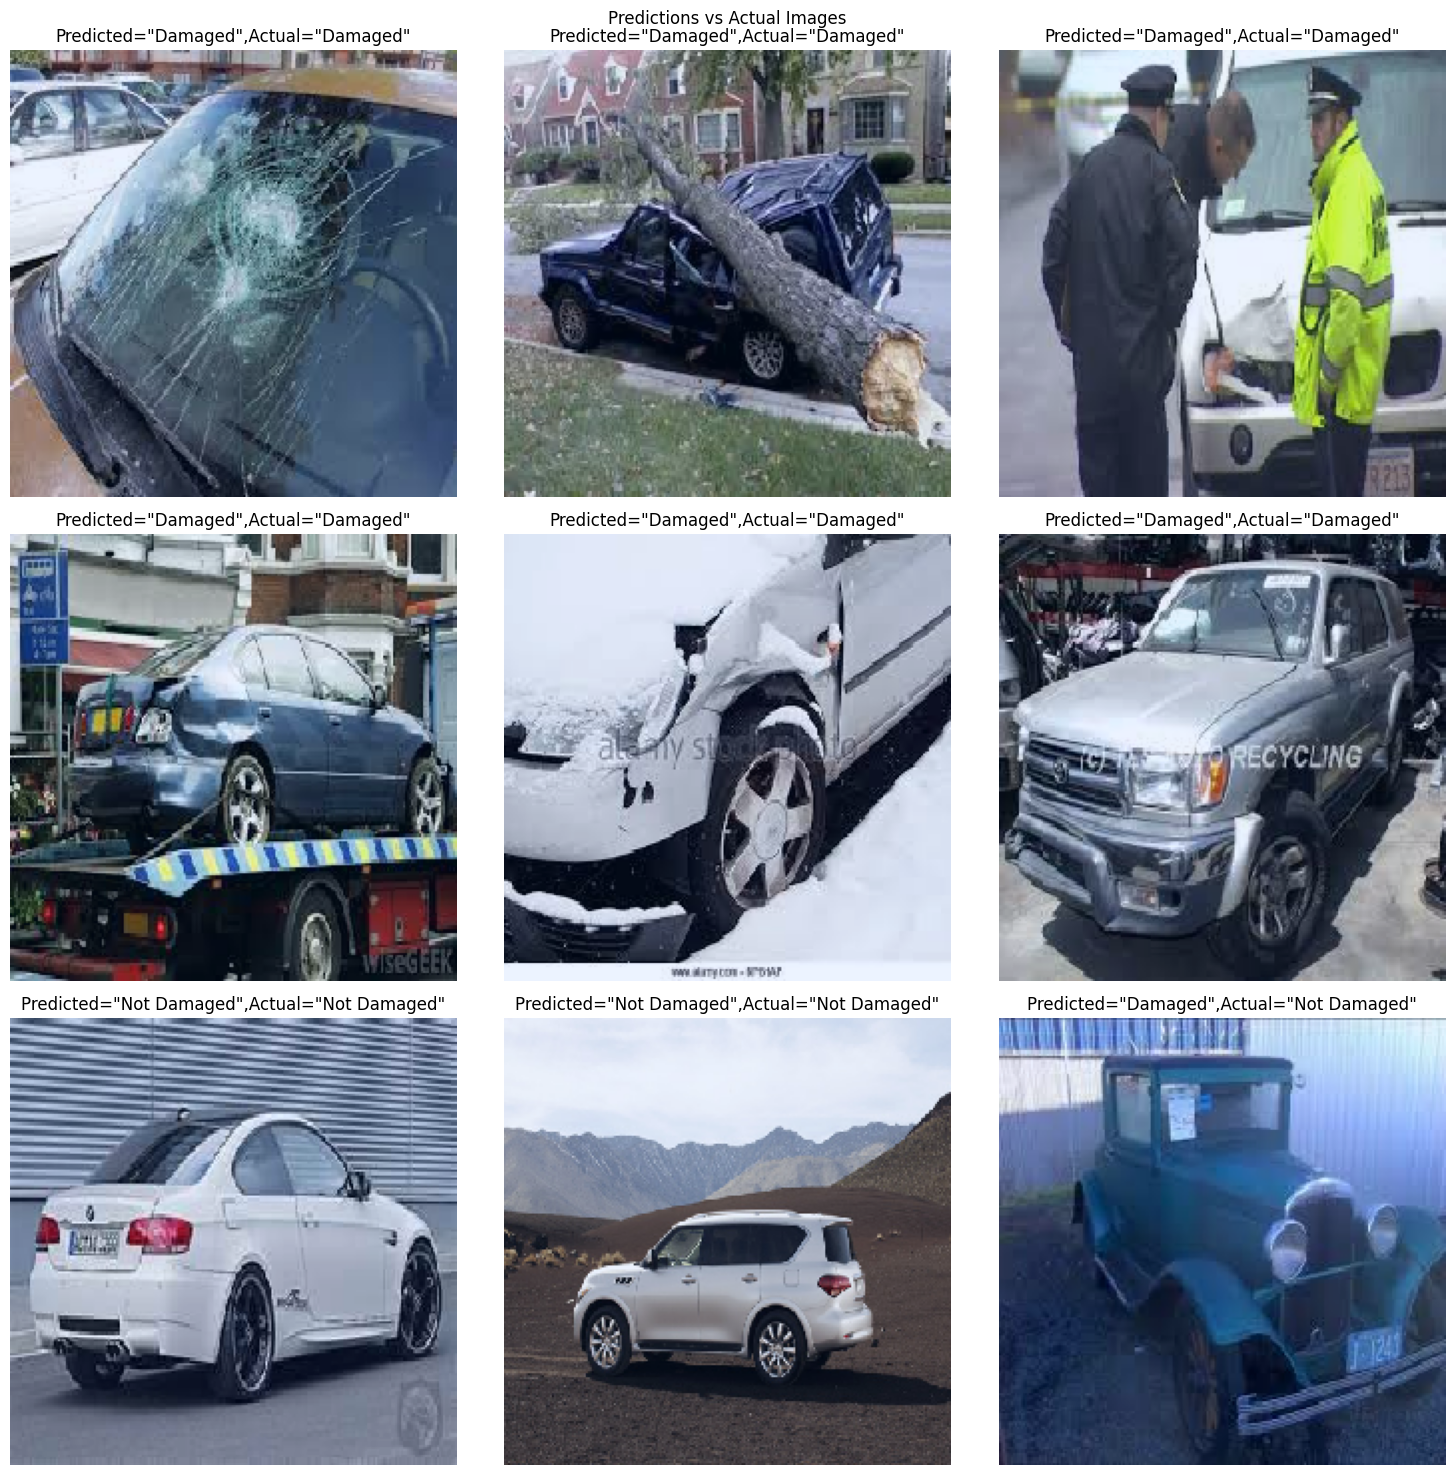

In [14]:
idxs = sorted(np.random.choice(460, 9, replace=False))
fig, axes = plt.subplots(3, 3, figsize=(15,15))
axes = axes.flatten()
for i, idx in enumerate(idxs):
    ax = axes[i]
    ax.imshow(array_to_img(pure_test_images[idx]))
    ax.axis('off')
    ax.set_title(f'Predicted="{predicted_label[idx]}",Actual="{real_labels[idx]}"')
plt.suptitle('Predictions vs Actual Images')
plt.tight_layout()
plt.show()